# Ensemble Methods
* Heterogeneous Models with different architecture trained on the full dataset
* Same model trained multiple times on the full dataset

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys

from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

from torchvision import datasets, models, transforms

# Base Directory where data is stored
PATH = '/media/rene/Data/camelyon_out/tiles_299_100t/'

fast_ai_dir = '/media/rene/Data/fastai/'
sys.path.append(fast_ai_dir)

# Add the src directory for functions
src_dir = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), 'src')
print(src_dir)
sys.path.append(src_dir)

# import my functions:
from WSI_pytorch_utils import*
from other_functions import*

# Set it to use GPU0
torch.cuda.set_device(0)
print(torch.cuda.is_available())
print(torch.cuda.current_device())

/media/rene/Data/camelyon/src
True
0


# Heterogeneous Ensemble
* Train with the entire dataset, but different architectures

In [ ]:
models_arch = [resnet34, resnet50, resnet101, vgg16, resnext50, resnext101, inceptionresnet_2, inception_4, dn121, dn169]
models_name = ['resnet34', 'resnet50', 'resnet101', 'vgg16', 'resnext50', 'resnext101', 'inceptionresnet_2', 'inception_4', 'dn121', 'dn169']

for idx, arch in enumerate(models_arch):
    print(models_name[idx])
    if arch in [inceptionresnet_2, inception_4]:
        sz = 299
        PATH = '/media/rene/Data/camelyon_out/tiles_224_100t'
    else:
        sz = 224
        PATH = '/media/rene/Data/camelyon_out/tiles_224_100t'
        
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1)
    data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=12)
    learn = ConvLearner.pretrained(arch, data, precompute=False)
    
    lr =.001
    learn.fit(lr, 1, cycle_len=1, cycle_mult=1) # train last few layers
    lrs = np.array([lr/4,lr/2,lr])
    learn.unfreeze()
    learn.fit(lrs, 3, cycle_len=1, cycle_mult=2, best_save_name=models_name[idx]+'_full') # train whole model

### Get ensemble accuracy

In [2]:
# skipping inception_4
PATH = '/media/rene/Data/camelyon_out/tiles_224_100t/'
models_arch = [resnet34, resnet50, resnet101, vgg16, resnext50, resnext101, inceptionresnet_2, dn121, dn169]
models_name = ['resnet34_full', 'resnet50_full', 'resnet101_full', 'vgg16_full', 'resnext50_full', 'resnext101_full', 'inceptionresnet_2_full', 'dn121_full', 'dn169_full']

perf = get_best_ensemble_acc(models_arch, models_name, PATH)

resnet34_full :    0.9437125748502994
resnet50_full :    0.9455688622754491
resnet101_full :    0.9453892215568862
vgg16_full :    0.9433532934131736
resnext50_full :    0.9466467065868264
resnext101_full :    0.9458682634730539
inceptionresnet_2_full :    0.9395209580838323
dn121_full :    0.9440718562874252
dn169_full :    0.9479041916167664
[0.11111 0.11111 0.11111 0.11111 0.11111 0.11111 0.11111 0.11111 0.11111]
Power: 0 Accuracy:  0.9519161676646707
[0.10452 0.11559 0.11445 0.10255 0.12273 0.11751 0.08426 0.10655 0.13184]
Power: 3 Accuracy:  0.9516766467065868
[0.09702 0.11864 0.11632 0.09339 0.13377 0.12264 0.06305 0.10082 0.15435]
Power: 6 Accuracy:  0.9513772455089821
[0.08897 0.12032 0.1168  0.08402 0.14405 0.12644 0.04661 0.09425 0.17854]
Power: 9 Accuracy:  0.9516766467065868
[0.0807  0.12068 0.116   0.07477 0.15342 0.12894 0.03408 0.08715 0.20426]
Power: 12 Accuracy:  0.9513173652694611
[0.07247 0.11984 0.11406 0.06587 0.16177 0.13018 0.02467 0.07977 0.23135]
Power: 15 Accu

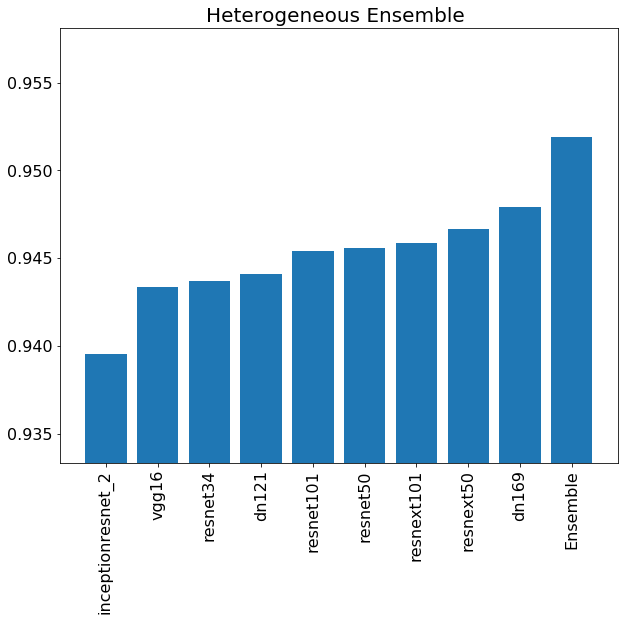

In [8]:
perf_all = perf + [0.9519161676646]
plot_names = [model.rsplit('_', 1)[0] for model in models_name]
plot_names = plot_names+['Ensemble']

perf_all, plot_names = (list(t) for t in zip(*sorted(zip(perf_all, plot_names))))

x = np.arange(len(plot_names))
low = min(perf_all)
high = max(perf_all)

fig, ax = plt.subplots(figsize=(10, 8))
plt.bar(plot_names, perf_all)
plt.xticks(x, plot_names)
plt.tick_params(labelsize=16)
plt.xticks(rotation=90)
plt.ylim([low-0.5*(high-low), high+0.5*(high-low)])
plt.title('Heterogeneous Ensemble ', fontsize=20)
plt.show()

fig.savefig('/media/rene/Data/camelyon_out/figures/heterogeneous_ensemble.jpeg', bbox_inches='tight', pad_inches=0)

## Single Architecture Ensemble
* DenseNet 169

In [46]:
arch = dn169
models_name = 'dn169_full'

lr=np.array([1e-3,5e-3,1e-2])

sz = 224
PATH = '/media/rene/Data/camelyon_out/tiles_224_100t'

for i in range(10):
    print(i)
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1)
    data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=24)
    learn = ConvLearner.pretrained(arch, data, precompute=False)
    
    lr =.001
    learn.fit(lr, 1, cycle_len=1, cycle_mult=1) # train last few layers
    lrs = np.array([lr/4,lr/2,lr])
    learn.unfreeze()
    learn.fit(lrs, 3, cycle_len=1, cycle_mult=2, best_save_name=models_name+'_'+str(i)) # train whole model

0


 13%|█▎        | 445/3471 [01:25<09:39,  5.22it/s, loss=0.29] 

KeyboardInterrupt: 

In [23]:
PATH = '/media/rene/Data/camelyon_out/tiles_224_100t'

models_arch = [dn169 for i in range(10)]
models_name = ['dn169_full_'+str(i) for i in range(10)]

perf = get_best_ensemble_acc(models_arch, models_name, PATH)

dn169_full_0 :    0.9473053892215569
dn169_full_1 :    0.9489820359281437
dn169_full_2 :    0.947185628742515
dn169_full_3 :    0.9474251497005988
dn169_full_4 :    0.9480838323353293
dn169_full_5 :    0.9469461077844311
dn169_full_6 :    0.9459880239520958
dn169_full_7 :    0.9487425149700599
dn169_full_8 :    0.9464670658682635
dn169_full_9 :    0.9488622754491018
[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
Power: 0 Accuracy:  0.9508383233532934
[0.09813 0.10813 0.09747 0.0988  0.10261 0.09615 0.09112 0.10662 0.09359 0.10737]
Power: 3 Accuracy:  0.9507784431137725
[0.09599 0.11655 0.0947  0.09731 0.10496 0.09216 0.08278 0.11332 0.08732 0.11492]
Power: 6 Accuracy:  0.9508982035928144
[0.09361 0.12523 0.09171 0.09554 0.10702 0.08805 0.07495 0.12006 0.08121 0.12261]
Power: 9 Accuracy:  0.9507784431137725
[0.09099 0.13413 0.08855 0.09351 0.10879 0.08387 0.06766 0.1268  0.07529 0.13041]
Power: 12 Accuracy:  0.9506586826347305
[0.08818 0.14322 0.08523 0.09124 0.11024 0.07963 0.06089 0.13351 

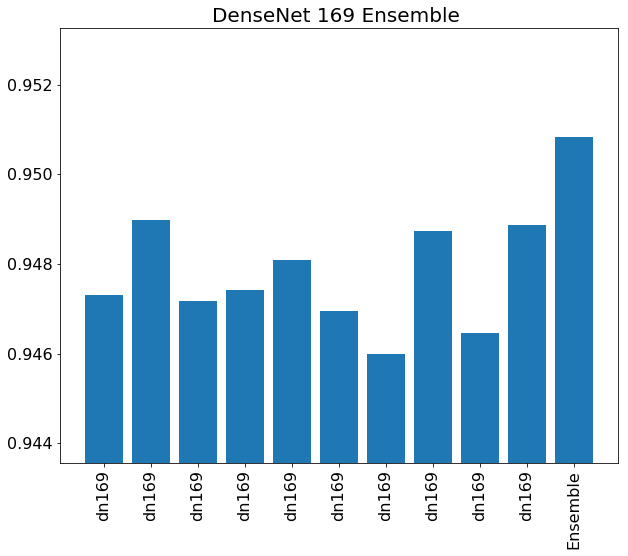

In [26]:
plot_names = [model.rsplit('_', 1)[0].rsplit('_', 1)[0] for model in models_name]
plot_names = plot_names + ['Ensemble']
perf_all = perf + [0.950838]

# perf_all, plot_names = (list(t) for t in zip(*sorted(zip(perf_all, plot_names))))

x = np.arange(len(plot_names))
low = min(perf_all)
high = max(perf_all)

fig, ax = plt.subplots(figsize=(10, 8))
plt.bar(range(len(plot_names)), perf_all)
plt.xticks(x, plot_names)
plt.tick_params(labelsize=16)
plt.xticks(rotation=90)
plt.ylim([low-0.5*(high-low), high+0.5*(high-low)])
plt.title('DenseNet 169 Ensemble ', fontsize=20)
plt.show()

fig.savefig('/media/rene/Data/camelyon_out/figures/dn169_ensemble.jpeg', bbox_inches='tight', pad_inches=0)

# Test Model Size vs. Ensemble Performance
* Train 5 models of each architecture on the full datset

In [ ]:
arch = resnet18
models_name = 'resnet18_full'

lr=np.array([1e-3,5e-3,1e-2])

sz = 224
PATH = '/media/rene/Data/camelyon_out/tiles_224_100t'

for i in range(5):
    print(i)
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1)
    data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=64)
    learn = ConvLearner.pretrained(arch, data, precompute=False)
    
    lr =.001
    learn.fit(lr, 1, cycle_len=1, cycle_mult=1) # train last few layers
    lrs = np.array([lr/4,lr/2,lr])
    learn.unfreeze()
    learn.fit(lrs, 3, cycle_len=1, cycle_mult=2, best_save_name=models_name+'_'+str(i)) # train whole model

0


epoch      trn_loss   val_loss   accuracy                      
    0      0.287159   0.247788   0.891976  



epoch      trn_loss   val_loss   accuracy                      
    0      0.20646    0.184503   0.920599  
    1      0.180768   0.162556   0.932635                      
    2      0.188344   0.159913   0.934192                      
    3      0.177259   0.14962    0.938024                      
    4      0.168639   0.153127   0.934012                      
    5      0.161502   0.153624   0.933293                      
    6      0.158739   0.148613   0.937365                      

1


epoch      trn_loss   val_loss   accuracy                      
    0      0.273645   0.252475   0.890599  



epoch      trn_loss   val_loss   accuracy                      
    0      0.208263   0.18727    0.91976   
    1      0.199342   0.167437   0.92988                       
    2      0.179781   0.1672     0.929701                      
    3      0.174061   0.158491   0.934192                      
    4      0.168368   0.151634   0.936527                      
    5      0.164343   0.151816   0.937844                      
    6      0.174296   0.150102   0.938563                      

2


epoch      trn_loss   val_loss   accuracy                      
    0      0.286319   0.253799   0.891257  



epoch      trn_loss   val_loss   accuracy                      
    0      0.21792    0.181607   0.923234  
    1      0.189015   0.160477   0.933054                      
    2      0.181705   0.157013   0.934611                      
    3      0.175684   0.152211   0.935269                      
    4      0.164098   0.14431    0.940299                      
    5      0.153495   0.145324   0.938862                      
    6      0.168139   0.146701   0.937964                      

3


epoch      trn_loss   val_loss   accuracy                      
    0      0.290365   0.252309   0.889521  



epoch      trn_loss   val_loss   accuracy                      
    0      0.210551   0.181161   0.924132  
    1      0.18992    0.161153   0.933593                      
    2      0.185731   0.16036    0.934371                      
    3      0.183232   0.155669   0.935449                      
    4      0.162197   0.149405   0.938084                      
    5      0.162431   0.146355   0.94024                       
    6      0.160341   0.144416   0.941377                      

4


epoch      trn_loss   val_loss   accuracy                      
    0      0.287338   0.238616   0.895749  



epoch      trn_loss   val_loss   accuracy                      
    0      0.205669   0.184046   0.920778  
 26%|██▋       | 344/1302 [01:02<02:53,  5.54it/s, loss=0.197]

In [ ]:
arch = resnet34
models_name = 'resnet34_full'

lr=np.array([1e-3,5e-3,1e-2])

sz = 224
PATH = '/media/rene/Data/camelyon_out/tiles_224_100t'

for i in range(5):
    print(i)
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1)
    data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=64)
    learn = ConvLearner.pretrained(arch, data, precompute=False)
    
    lr =.001
    learn.fit(lr, 1, cycle_len=1, cycle_mult=1) # train last few layers
    lrs = np.array([lr/4,lr/2,lr])
    learn.unfreeze()
    learn.fit(lrs, 3, cycle_len=1, cycle_mult=2, best_save_name=models_name+'_'+str(i)) # train whole model

In [ ]:
arch = resnet50
models_name = 'resnet50_full'

lr=np.array([1e-3,5e-3,1e-2])

sz = 224
PATH = '/media/rene/Data/camelyon_out/tiles_224_100t'

for i in range(5):
    print(i)
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1)
    data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=64)
    learn = ConvLearner.pretrained(arch, data, precompute=False)
    
    lr =.001
    learn.fit(lr, 1, cycle_len=1, cycle_mult=1) # train last few layers
    lrs = np.array([lr/4,lr/2,lr])
    learn.unfreeze()
    learn.fit(lrs, 3, cycle_len=1, cycle_mult=2, best_save_name=models_name+'_'+str(i)) # train whole model

In [ ]:
arch = resnet101
models_name = 'resnet101_full'

lr=np.array([1e-3,5e-3,1e-2])

sz = 224
PATH = '/media/rene/Data/camelyon_out/tiles_224_100t'

for i in range(5):
    print(i)
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1)
    data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=64)
    learn = ConvLearner.pretrained(arch, data, precompute=False)
    
    lr =.001
    learn.fit(lr, 1, cycle_len=1, cycle_mult=1) # train last few layers
    lrs = np.array([lr/4,lr/2,lr])
    learn.unfreeze()
    learn.fit(lrs, 3, cycle_len=1, cycle_mult=2, best_save_name=models_name+'_'+str(i)) # train whole model

### Get performance
* Look at how average model perfromace and the ensemble performance vary with model size
* Look at variance of the predictors?

In [2]:
%xmode verbose

Exception reporting mode: Verbose


In [2]:
PATH = '/media/rene/Data/camelyon_out/tiles_224_100t'

PATH = '/media/rene/Data/camelyon_out/tiles_224_100t/'
models_path = '/media/rene/Data/camelyon_out/tiles_224_100t/'

models_arch = [resnet18]*5
models_name = ['resnet18_full_'+str(i) for i in range (5)]
acc_r18, acc_list_r18, int_acc_list_r18 = ensemble_acc_dir(models_arch, 
                                                                   models_name, models_path, PATH, weights=None)

models_arch = [resnet34]*5
models_name = ['resnet34_full_'+str(i) for i in range (5)]
acc_r34, acc_list_r34, int_acc_list_r34 = ensemble_acc_dir(models_arch, 
                                                                   models_name, models_path, PATH, weights=None)

models_arch = [resnet50]*5
models_name = ['resnet50_full_'+str(i) for i in range (5)]
acc_r50, acc_list_r50, int_acc_list_r50 = ensemble_acc_dir(models_arch, 
                                                                   models_name, models_path, PATH, weights=None)

models_arch = [resnet101]*5
models_name = ['resnet101_full_'+str(i) for i in range (5)]
acc_r101, acc_list_r101, int_acc_list_r101 = ensemble_acc_dir(models_arch, 
                                                                   models_name, models_path, PATH, weights=None)

resnet18_full_0 :    0.9380239520958084
resnet18_full_1 :    0.938562874251497
resnet18_full_2 :    0.9402994011976048
resnet18_full_3 :    0.941377245508982
resnet18_full_4 :    0.9358083832335329
0.941377245508982
resnet34_full_0 :    0.9398802395209581
resnet34_full_1 :    0.9402994011976048
resnet34_full_2 :    0.9410179640718563
resnet34_full_3 :    0.9413173652694611
resnet34_full_4 :    0.9432934131736527
0.9423952095808383
resnet50_full_0 :    0.9440718562874252
resnet50_full_1 :    0.9449700598802395
resnet50_full_2 :    0.9423952095808383
resnet50_full_3 :    0.9432934131736527
resnet50_full_4 :    0.942934131736527
0.9463473053892215
resnet101_full_0 :    0.9454491017964072
resnet101_full_1 :    0.9468862275449101
resnet101_full_2 :    0.9437125748502994
resnet101_full_3 :    0.9465868263473054
resnet101_full_4 :    0.9474850299401197
0.948443113772455


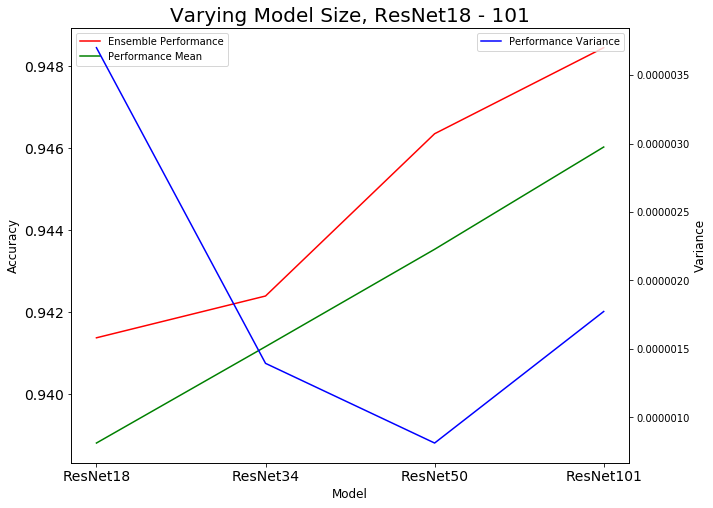

In [21]:
names = ['ResNet18', 'ResNet34', 'ResNet50', 'ResNet101']
data = [acc_list_r18, acc_list_r34, acc_list_r50, acc_list_r101]

mean_all = [np.mean(perf) for perf in data]
var_all = [np.var(perf) for perf in data]
perf_all = [acc_r18, acc_r34, acc_r50, acc_r101]

x = np.arange(len(names))
fig, ax1 = plt.subplots(figsize=(10, 8))
ax2 = ax1.twinx()

ax1.plot(x, perf_all, color='r')
ax1.plot(x, mean_all, color='g')

ax1.set_xlabel('Model', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)

ax2.plot(x, var_all, color='b')
ax2.set_ylabel('Variance', fontsize=12)

ax1.legend(['Ensemble Performance', 'Performance Mean'], loc='upper left')
ax2.legend(['Performance Variance'], loc='upper right')

plt.xticks(x, names)
ax1.tick_params(labelsize=14)

plt.title('Varying Model Size, ResNet18 - 101', fontsize=20)
plt.show()

fig.savefig('/media/rene/Data/camelyon_out/figures/model_size.jpeg', bbox_inches='tight', pad_inches=0)

# Overall Performance Comparision